# Marco Lavorini - Assignment 3

### dataset
Vito,Saverio. (2016). Air Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [70]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [71]:
# drop columns except for the target column 
df = X.drop(['Date','Time','CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH'], axis=1)
df = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']]
# the null values are marked as '-200'
df = df[df['C6H6(GT)'] != -200]
df = df[df['PT08.S1(CO)'] != -200]
df = df[df['PT08.S2(NMHC)'] != -200]
df = df[df['PT08.S3(NOx)'] != -200]
df = df[df['PT08.S4(NO2)'] != -200]
df = df[df['PT08.S5(O3)'] != -200]


In [72]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),C6H6(GT)
0,1360,1046,1056,1692,1268,11.9
1,1292,955,1174,1559,972,9.4
2,1402,939,1140,1555,1074,9.0
3,1376,948,1092,1584,1203,9.2
4,1272,836,1205,1490,1110,6.5


# Data splitting

we decided to split the data into 80% train and 20% test. Furthermore, since the values of the 'CO' column are in a sparse range, we extract now a 20% of the train set to use as validation set. This is done to fit the scaler only on the training set without the 'future' data which should not be know, as the validation and test set.

In [73]:
# split into train and test sets
dataset = df.values

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(train_size, validation_size, test_size)
print(len(dataset))
print(train_size + validation_size + test_size)

5754 1438 1799
8991
8991


In [74]:
# normalize the dataset
X_ = dataset[:, :-1]
y_ = dataset[:, -1]
train_X, train_y = X_[:train_size], y_[:train_size]
validation_X, validation_y = X_[train_size:train_size+validation_size], y_[train_size:train_size+validation_size]
test_X, test_y = X_[train_size+validation_size:], y_[train_size+validation_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
validation_X = scaler.transform(validation_X)
test_X = scaler.transform(test_X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
validation_y = scaler_y.transform(validation_y.reshape(-1, 1))
test_y = scaler_y.transform(test_y.reshape(-1, 1))

# reshape outputs, maybe need to reshape X to have the step embeddend in the shape, it would be (n x 1 x m) instead of n x m

In [75]:
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(5754, 5) (5754, 1) (1438, 5) (1438, 1) (1799, 5) (1799, 1)
(5754, 1, 5) (5754, 1) (1438, 1, 5) (1438, 1) (1799, 1, 5) (1799, 1)


In [85]:
train_X.shape[1], train_X.shape[2]

(1, 5)

In [87]:
model =  Sequential()

model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(6))
model.add(Dropout(0.2))
model.add(Dense(1))


In [88]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [89]:
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6)              │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295 (1.15 KB)

 Trainable params: 295 (1.15 KB)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
history = model.fit(train_X, train_y, validation_data=[validation_X, validation_y], epochs=20, batch_size=50, verbose=1, shuffle=False)

Epoch 1/20


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - val_loss: 0.0068
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0066 - val_loss: 0.0041
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0050 - val_loss: 0.0035
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0036 - val_loss: 0.0030
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1

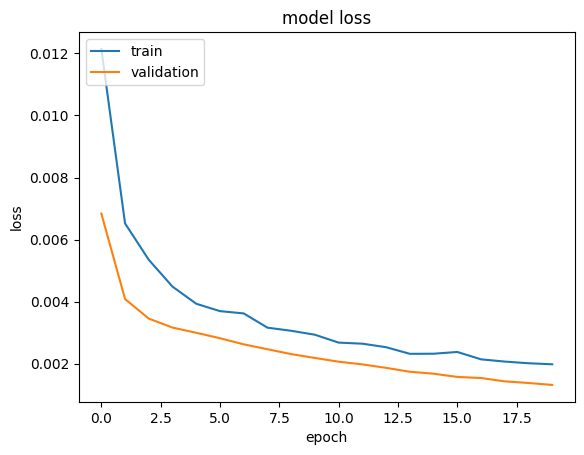

In [42]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [43]:
predict = model.predict(test_X)
predict.shape

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1799, 1)

In [45]:
predict = scaler_y.inverse_transform(predict)

In [46]:
# calculate root mean squared error
test_y = scaler_y.inverse_transform(test_y)
rmse = math.sqrt(mean_squared_error(test_y, predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.622


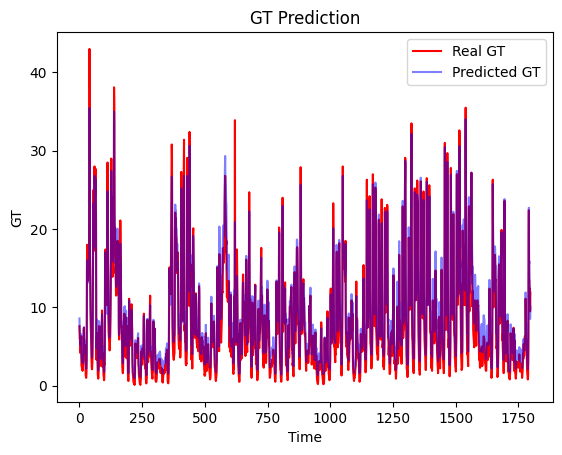

In [47]:
# plot the data
plt.plot(test_y, color = 'red', label = 'Real GT')
plt.plot(predict, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

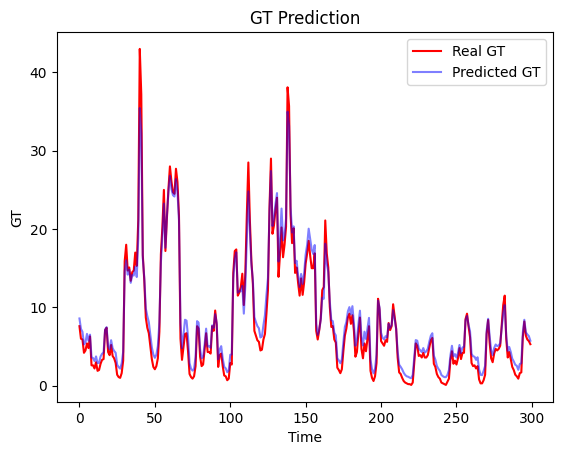

In [48]:
# plot the prediction more readable
plt.plot(test_y[0:300], color = 'red', label = 'Real GT')
plt.plot(predict[0:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

---

# second model

create the dataset with x 

In [49]:
X_2, y_2 = [], []
for i in range(len(y_)-1):
    X_2.append(y_[i])
    y_2.append(y_[i+1])
X_2 = np.array(X_2)
y_2 = np.array(y_2)

In [50]:
print(X_2.shape, y_2.shape)

(8990,) (8990,)


In [51]:
# split into train and test sets
dataset = df.values

train_size = int(len(X_2) * 0.8)
test_size = len(X_2) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(train_size, validation_size, test_size)
print(len(X_2))
print(train_size + validation_size + test_size)

5754 1438 1798
8990
8990


In [52]:
x_train, y_train = X_2[:train_size], y_2[:train_size]
x_validation, y_validation = X_2[train_size:train_size+validation_size], y_2[train_size:train_size+validation_size]
x_test, y_test = X_2[train_size+validation_size:], y_2[train_size+validation_size:]

In [53]:
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_validation = scaler.transform(x_validation.reshape(-1, 1))
x_test = scaler.transform(x_test.reshape(-1, 1))

y_train = scaler.transform(y_train.reshape(-1, 1))
y_validation = scaler.transform(y_validation.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [54]:
print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1) (5754, 1) (1438, 1) (1438, 1) (1798, 1) (1798, 1)


In [55]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_validation = np.reshape(x_validation, (x_validation.shape[0], 1, x_validation.shape[1]))

x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1, 1) (5754, 1) (1438, 1, 1) (1438, 1) (1798, 1, 1) (1798, 1)


# model 2, the same for different data

In [56]:
model2 =  Sequential()

model2.add(LSTM(4, input_shape=(x_train.shape[1], x_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1))

/Users/lavo/Desktop/Projects/ISPR-Midterms/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
print(model2.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [59]:
history = model2.fit(x_train, y_train, validation_data=[x_validation, y_validation], epochs=20, batch_size=50, verbose=1, shuffle=False)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0383 - val_loss: 0.0195
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0151 - val_loss: 0.0164
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0138 - val_loss: 0.0144
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0125 - val_loss: 0.0125
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0114 - val_loss: 0.0107
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0104 - val_loss: 0.0092
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0096 - val_loss: 0.0081
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0091 - val_loss: 0.0074
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0087 - val_loss: 0.0070
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0085 - val_loss: 0.0068
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0078 - val_loss: 0.0066
Epoch 12/20
116/116 ━━━━━━━━━━━━

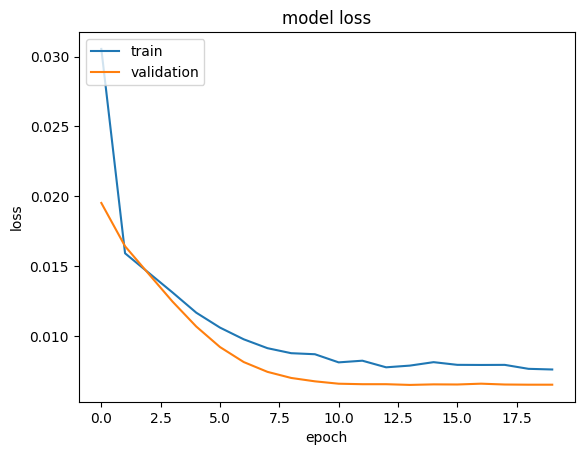

In [60]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [61]:
predict2 = model2.predict(x_test)
predict2.shape

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1798, 1)

In [62]:
predict2 = scaler.inverse_transform(predict2)

In [63]:
# calculate root mean squared error
y_test = scaler.inverse_transform(y_test)
rmse2 = math.sqrt(mean_squared_error(y_test, predict2))
print('Test RMSE: %.3f' % rmse2)


Test RMSE: 3.951


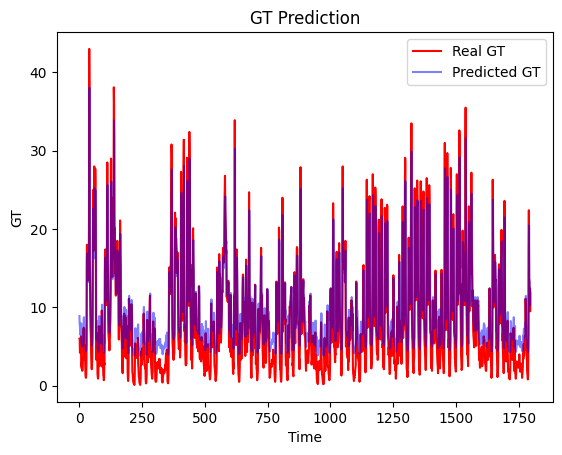

In [64]:
# plot the data
plt.plot(y_test, color = 'red', label = 'Real GT')
plt.plot(predict2, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

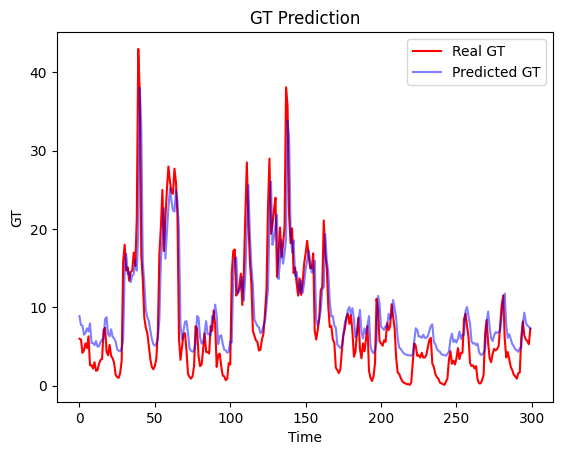

In [65]:
# plot the data
plt.plot(y_test[:300], color = 'red', label = 'Real GT')
plt.plot(predict2[:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

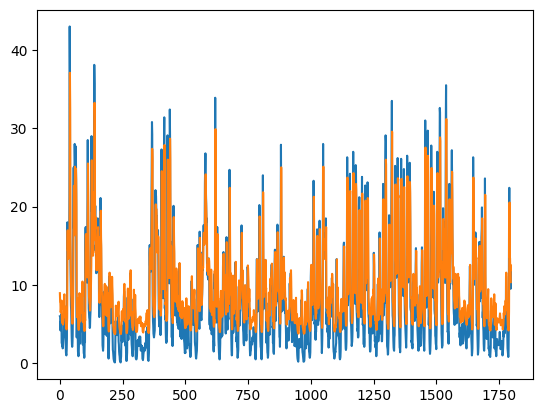

In [224]:
# fill the distance of the 2 function with seaborn
import seaborn as sns
sns.lineplot(x=range(len(y_test)), y=y_test.reshape(-1))
sns.lineplot(x=range(len(predict2)), y=predict2.reshape(-1))


plt.show()



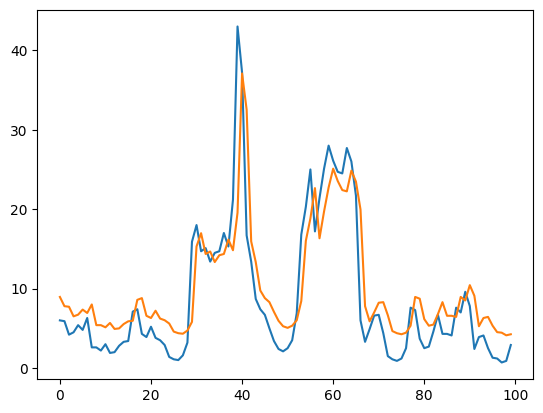

In [225]:
# zoom first 100 values
sns.lineplot(x=range(100), y=y_test[:100].reshape(-1))
sns.lineplot(x=range(100), y=predict2[:100].reshape(-1))
plt.show()
